In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Entanglement of a pair of quantum emitters via continuous fluorescence measurements: a tutorial

### SME - ENTANGLEMENT BY JOINT HOMODYNE DETECTION OF FLUORESCENCE, Chap.5

In [7]:
def theo_concurrence(t, gamma):
    return 2*np.exp(-gamma*t)*(1-np.exp(-gamma*t)) 

def concurrence_pure_state(state): 
    ###Compute the concurrence for a pure state
    return 2*np.abs(state[0]*state[3]-state[1]*state[2])

def compute_concurrences(solution):
    ntraj = len(solution.runs_states)
    n_times = len(solution.runs_states[0])  # si assume che tutte le traiettorie abbiano stesso numero di time step

    conc_array = np.zeros((ntraj, n_times))

    for traj_idx in range(ntraj):
        for t_idx, state in enumerate(solution.runs_states[traj_idx]):

            if state.isket:
                conc_array[traj_idx, t_idx] = concurrence_pure_state(state) #Use fast method for pure states
            else:               
                conc_array[traj_idx, t_idx] = concurrence(state)

    return conc_array

def compute_mean_concurrence(conc_array):
    mean_conc = np.mean(np.array(conc_array), axis=0)
    return mean_conc

In [8]:
#  Convenzione: |e> = (1,0) and |g> = (0,1)

# parameters
GAMMA = 1              # Atom decay rate
OMEGA = 1
T_1 = 1 / GAMMA  # time constant for the decay
ntraj = 1000 # number of trajectories
I_2 = qeye(2)  # identity operator for 2-level system
sm = sigmam()  # lowering operator for 2-level system (atom)

# operators
sigma_minus_1 = tensor(sm, I_2) # lowering operator for atom 1
sigma_minus_2 = tensor(I_2, sm) # lowering operator for atom 2
sigma_minus_12 = tensor(sigma_minus_1, sigma_minus_2) # combined lowering operator for both atoms    

sigma_plus_1 = sigma_minus_1.dag() # raising operator for atom 1
sigma_plus_2 = sigma_minus_2.dag() # raising operator for atom       
sigma_plus_12 = tensor(sigma_plus_1, sigma_plus_2) # raising operator for both atoms

H_free_atom_1 = 0.5 * OMEGA * tensor(sigmaz(), I_2) # Free Hamiltonian atom 1
H_free_atom_2 = 0.5 * OMEGA * tensor(I_2, sigmaz()) # Free Hamiltonian atom 2
H_free = H_free_atom_1 + H_free_atom_2 # Free Hamiltonian for both atoms        

ee = tensor(basis(2, 0), basis(2, 0))# initial vector state, |e, e> (the atoms must decay from the excited state!)
times = np.arange(0, 3, 0.0001) # time vector

In [9]:
# solve the master equation using the stochastic master equation with photodetection
#Without dt doesn't work ?!?!?!?!
ee_solutions_jhom = ssesolve(
    H_free, ee, times,
    sc_ops=[np.exp(1j * np.pi / 2)*np.sqrt(GAMMA/2) * (sigma_minus_1+sigma_minus_2), np.sqrt(GAMMA/2) * (sigma_minus_1-sigma_minus_2)],  # Two stochastic collapse operators 
    ntraj=ntraj,
    options={"dt": 0.0001, "store_states": True, "keep_runs_results": True},
)

10.0%. Run time: 409.87s. Est. time left: 00:01:01:28
20.0%. Run time: 831.73s. Est. time left: 00:00:55:26
30.0%. Run time: 1266.79s. Est. time left: 00:00:49:15
40.0%. Run time: 1703.79s. Est. time left: 00:00:42:35
50.0%. Run time: 2194.60s. Est. time left: 00:00:36:34
60.0%. Run time: 3169.12s. Est. time left: 00:00:35:12
70.0%. Run time: 4210.68s. Est. time left: 00:00:30:04
80.0%. Run time: 4998.54s. Est. time left: 00:00:20:49
90.0%. Run time: 6043.59s. Est. time left: 00:00:11:11
100.0%. Run time: 6510.05s. Est. time left: 00:00:00:00
Total run time: 6520.98s


In [4]:
#B_10_solutions_jhom = ssesolve(
    #H_free, bell_state("10"), times,
    #sc_ops=[np.sqrt(GAMMA) * (sigma_minus_1+sigma_minus_2)/np.sqrt(2), np.sqrt(GAMMA) * (sigma_minus_1-sigma_minus_2)/np.sqrt(2)],  # Two stochastic collapse operators 
    #ntraj=ntraj,
    #options={"store_states": True, "keep_runs_results": True},
#)

In [15]:
with open("conc.txt", "w") as file:
    file.write("\n".join(str(e) for e in mean_conc_ee_solutions_jhom))

In [12]:
my_exp = ee_solutions_jhom

conc_ee_solutions_jhom = compute_concurrences(my_exp)
mean_conc_ee_solutions_jhom = compute_mean_concurrence(conc_ee_solutions_jhom)

C:\Users\campa\AppData\Local\Temp\ipykernel_5092\2207448988.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conc_array[traj_idx, t_idx] = concurrence_pure_state(state) #Use fast method for pure states


In [34]:
print(len(times))
print(len(mean_conc_ee_solutions_jhom))
print(len(conc_ee_solutions_jhom[10,:]))

3000
3000
3000


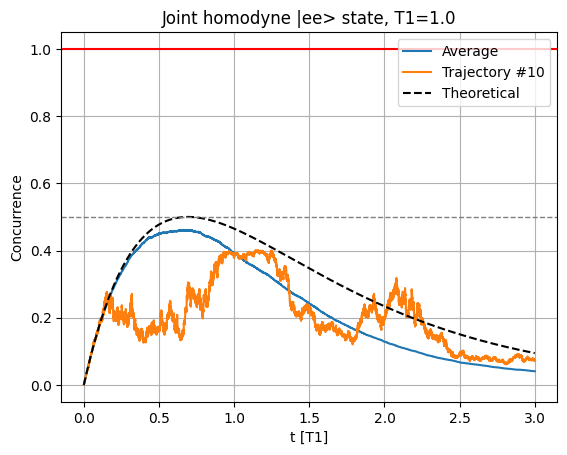

In [ ]:
line1, = plt.plot(times, mean_conc_ee_solutions_jhom, label="Average")
line2, = plt.plot(times, conc_ee_solutions_jhom[11], label="Trajectory #10")
line3, = plt.plot(times, theo_concurrence(times, GAMMA), color='black', linestyle ='--', label="Theoretical")

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label='y = 0.5')
plt.axhline(y=1, color='red', linestyle='-', linewidth=1.5, label='y = 1')

plt.xlabel("t [T1]")
plt.ylabel("Concurrence")
plt.title(f"Joint homodyne |ee> state, T1={T_1}")
plt.grid(True)
plt.legend(handles = [line1, line2, line3])
plt.show()



Five different Kraus operators! They form a complete set of outcomes s.t. they "add" to identity. Then we may draw a number from a multinomial distribution at every time step, each
possibility of which corresponds to a given detector outcom

In [10]:
#Evolution with Kraus operators

eps = 0.1 
sqrt = np.sqrt  #Keep it short

# M_00
M_00 = Qobj([
    [1 - eps,      0,           0,        0],
    [0,      sqrt(1 - eps),     0,        0],
    [0,            0,     sqrt(1 - eps),  0],
    [0,            0,           0,        1]
])

# M_10
M_10 = Qobj([
    [0, 0, 0, 0],
    [sqrt(eps * (1 - eps)/ 2) , 0, 0, 0],
    [sqrt(eps * (1 - eps)/ 2), 0, 0, 0],
    [0, sqrt(eps/2), sqrt(eps/2), 0]
])

# M_01
M_01 = Qobj([
    [0, 0, 0, 0],
    [-sqrt(eps * (1 - eps)/ 2) , 0, 0, 0],
    [sqrt(eps * (1 - eps)/ 2), 0, 0, 0],
    [0, sqrt(eps/2), -sqrt(eps/2), 0]
])

# M_20
M_20 = Qobj([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [eps / sqrt(2), 0, 0, 0]
])

# M_02
M_02 = Qobj([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [-eps / sqrt(2), 0, 0, 0]
])

kraus_ops = [M_00, M_10, M_01, M_20, M_02]

#Probabilities:

def compute_weights(q1, q2, q3, q4, gamma, dt):
    # Calcolo di Xi e Theta
    Xi = 1 + q1 / np.sqrt(2) + q2 / np.sqrt(6) + 2 * q3 / np.sqrt(3) #Squared symbol
    Theta = 1/4 + q1 / np.sqrt(2) + q2 / np.sqrt(6) + q3 / (2 * np.sqrt(3))

    # Coefficienti w_ij
    w_00 = 1 - dt * gamma * Xi + dt**2 * gamma**2 * Theta
    w_10 = gamma * dt * (3/2 - q4 / np.sqrt(2)) - gamma**2 * dt**2 * Theta
    w_01 = gamma * dt * (3/2 + q4 / np.sqrt(2)) - gamma**2 * dt**2 * Theta
    w_02 = gamma**2 * dt**2 / 2
    w_20 = w_02